In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
filename = '/content/drive/MyDrive/TimeSeries/TimeSeries_practice/train.csv'

**Local에서 data load**

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import io
import pandas as pd
df = pd.read_csv(io.StringIO(uploaded['train.csv'].decode('utf-8')))

#***TimeSeries - ARIMA***

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from pylab import rcParams
import statsmodels.api as sm #회귀, 시계열 분석 등에 기능을 제공
import warnings
import itertools
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv(filename)
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


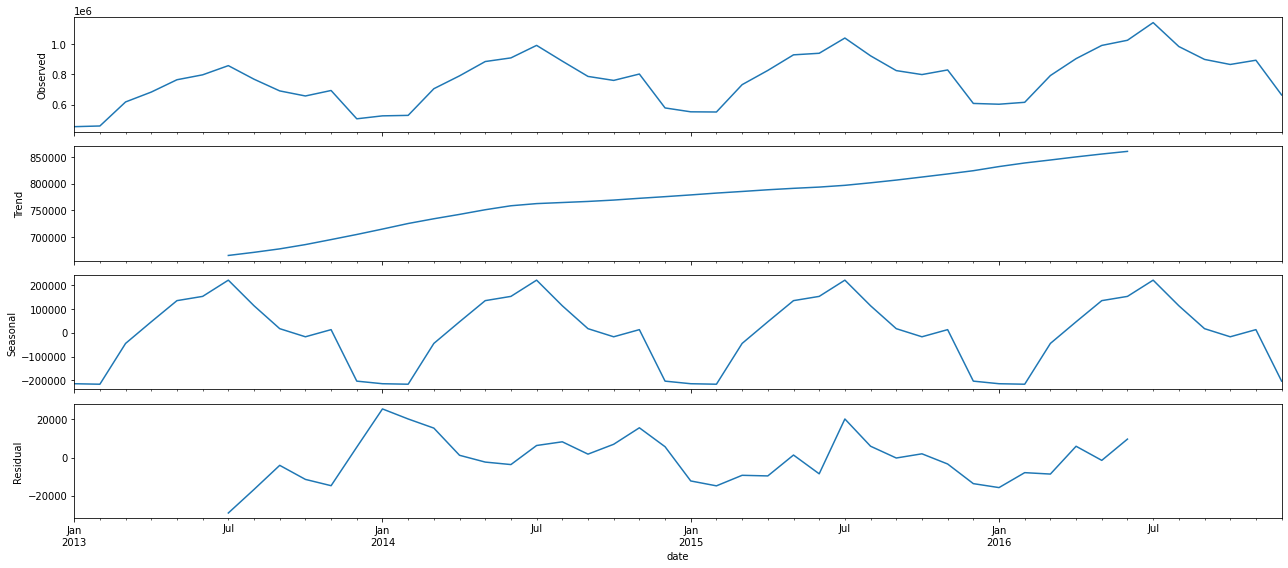

In [ ]:
# string 형태의 date 필드를 datetime 형태로 변환
df['date'] =  pd.to_datetime(df['date'])

# date 필드를 index로 설정
df = df.set_index('date')

# 빠르게 테스트 해 보기 위해 월별로 아이템 판매 예측을 해 보기로 함
salesbymonth = df.sales.resample('M').sum()

#2013-2016 데이터를 train으로 2017 데이터를 test로 분리
split = "2017-01-01"
salesbymonth_train= salesbymonth[:split]
salesbymonth_test= salesbymonth[split:]
salesbymonth_test_final=salesbymonth_test.copy()

# 데이터를 시즌별로 분해해서 살펴 봄
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(salesbymonth_train, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
df.isna().sum()

store    0
item     0
sales    0
dtype: int64

In [ ]:
df['store'].fillna(df['store'].mean(), inplace = True)
df['item'].fillna(df['item'].mean(), inplace = True)
df['sales'].fillna(df['sales'].mean(), inplace = True)

In [ ]:
p = d = q = range(0, 2)

import itertools
pdqa = list(itertools.product(p, d, q)) #p,d,q의 곱으로 iterator로 변환

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
#우리가 아는 계절은 12달이므로 마지막 12는 12달의 12를 의미!

for param in pdqa:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(salesbymonth_train, 
                                            order=param, #arima의 p,d,q
                                            seasonal_order=param_seasonal, 
                                            enforce_stationarity=False,enforce_invertibility=False
                                            #e_s = AR이 정상성을 만족하게 끔 강제로 하는 것,
                                            #e_i = MA가 정상성을 만족하게 끔 가엦로 하는 것
                                            )
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

# **SARIMAX란?**

```
from statsmodels.tsa.statespace.sarimax import SARIMAX

```

ARIMAX 모형에서 계절성 패턴(S)을 추가한 모델로 SARIMAX의 X는 외부 변수를 나타내는 eXogeneous의 줄임말로 학습과 예측에 포함시킬 수 있다.

- 주요파라미터

*   endog : 입력할 시계열 데이터
*   exog : 외부 변수 데이터
*   order : ARIMA의 p,d,q
*   seasonal_order : SARIMA의 seasonal component (P,D,Q,S)(단, 여기서 S는 시계열 데이터의 계절항목으로 예를 들어 월별 예측시 S는 12)
*   enforce_stationarity : AR항이 강제로 정상성을 띠게 함(default = TRUE)
*   enforce_invertibility : MA항이 강제로 정상성을 띠게 함(default = TRUE)

In [ ]:
SARIMAMonth = sm.tsa.statespace.SARIMAX(salesbymonth_train, order=(0, 1, 0), 
                                        seasonal_order=(1, 1, 0, 12) ,enforce_stationarity=False,
                                        enforce_invertibility=False)

SARIMA_results_month = SARIMAMonth.fit()

In [ ]:
#2017년 12개월 데이터로 예측 평가
SARIMA_predict_month_1 = SARIMA_results_month.predict(start=48,end=59)

In [ ]:
SARIMA_predict_month_1

2017-01-31    6.595467e+05
2017-02-28    6.729175e+05
2017-03-31    8.486108e+05
2017-04-30    9.607713e+05
2017-05-31    1.046578e+06
2017-06-30    1.081983e+06
2017-07-31    1.199025e+06
2017-08-31    1.039296e+06
2017-09-30    9.554046e+05
2017-10-31    9.217681e+05
2017-11-30    9.494186e+05
2017-12-31    7.208864e+05
Freq: M, dtype: float64

In [ ]:
np.set_printoptions(precision=6, suppress=True)
pd.options.display.float_format = '{:.5f}'.format

In [ ]:
salesbymonth_test_final

date
2017-01-31     617306
2017-02-28     621369
2017-03-31     822667
2017-04-30     938862
2017-05-31    1020686
2017-06-30    1064624
2017-07-31    1171393
2017-08-31    1026403
2017-09-30     935263
2017-10-31     891160
2017-11-30     928837
2017-12-31     695170
Freq: M, Name: sales, dtype: int64

In [ ]:
#결과 비교를 위해 기존에 test데이터와 결과를 붙임

df1 = pd.concat([SARIMA_predict_month_1, salesbymonth_test], axis=1)
df1.rename(columns = {0: 'ARIMA'}, inplace = True)
df1

,ARIMA,sales
2017-01-31,659546.70307,617306
2017-02-28,672917.51131,621369
2017-03-31,848610.80411,822667
2017-04-30,960771.34146,938862
2017-05-31,1046577.83168,1020686
2017-06-30,1081982.63674,1064624
2017-07-31,1199024.63568,1171393
2017-08-31,1039296.12553,1026403
2017-09-30,955404.59550,935263
2017-10-31,921768.14759,891160


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
RMSE_score_arima  = sqrt(mean_squared_error(df1['sales'], df1['ARIMA']))
RMSE_score_arima

28756.963875578564

In [ ]:
df1.plot()

In [ ]:
import math
MSE = np.square(np.subtract(df1['sales'],df1['ARIMA'])).mean() 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

28756.963875578564


#***TimeSeries - ML***

In [ ]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder
import csv
warnings.filterwarnings('ignore')

In [ ]:
df_ml = pd.read_csv(filename)
df_ml.head(3)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14


In [ ]:
#####USING XGBOOST######
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
from datetime import datetime

In [ ]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:
df_ml.head(3)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14


In [ ]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

<Figure size 2160x1080 with 0 Axes>

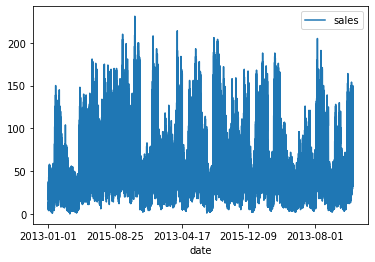

In [ ]:
plt.figure(figsize=(30,15))
df_ml.plot(x='date',y='sales')
plt.show()

In [ ]:
df_ml['date'] = pd.to_datetime(df_ml['date'])
df_ml = df_ml.set_index('date')

In [ ]:
# store/item 별로 월별 판매 합산
# df_ml = df_ml.sales.resample('M').sum()
df_ml = df_ml.groupby(['store','item'])['sales'].resample('M').sum() #월별 상점과 아이템 별 판매량 합산
df_ml = df_ml.reset_index()
df_ml = df_ml.set_index('date') #1번째 열 date로 바꿔주기

df_ml['month'] = df_ml.index.month
df_ml['year'] = df_ml.index.year
df_ml['dayofweek'] = df_ml.index.dayofweek

In [ ]:
df_ml

,store,item,sales,month,year,dayofweek
date,,,,,,
2013-01-31,1,1,328,1,2013,3
2013-02-28,1,1,322,2,2013,3
2013-03-31,1,1,477,3,2013,6
2013-04-30,1,1,522,4,2013,1
2013-05-31,1,1,531,5,2013,4
...,...,...,...,...,...,...
2017-08-31,10,50,2867,8,2017,3
2017-09-30,10,50,2586,9,2017,5
2017-10-31,10,50,2507,10,2017,1


In [ ]:
print(df_ml.head(5))

print('---------------------------')

print(df_ml.tail(5))

            store  item  sales  month  year  dayofweek
date                                                  
2013-01-31      1     1    328      1  2013          3
2013-02-28      1     1    322      2  2013          3
2013-03-31      1     1    477      3  2013          6
2013-04-30      1     1    522      4  2013          1
2013-05-31      1     1    531      5  2013          4
---------------------------
            store  item  sales  month  year  dayofweek
date                                                  
2017-08-31     10    50   2867      8  2017          3
2017-09-30     10    50   2586      9  2017          5
2017-10-31     10    50   2507     10  2017          1
2017-11-30     10    50   2574     11  2017          3
2017-12-31     10    50   1987     12  2017          6


In [ ]:
df_ml

In [ ]:
# 학습과 테스트 데이터 분리(2013~2016는 train, 2017은 test)
split = "2017-01-01"
df_train = df_ml[:split]
df_test = df_ml[split:]

df_train_y = df_train.loc[:,'sales'] #모든행을 표시하고 sales열만 가져오기
df_train_x = df_train.drop('sales', axis=1) #sales를 제외하고 모든 행, 열 가져오기
df_test_y = df_test.loc[:,'sales']
df_test_x = df_test.drop('sales', axis=1)
# 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
# df_test_orig = df_test.loc[:, ['store', 'item', 'sales']]

# **XGBRegressor란?**

- 분류/회귀 문제를 해결할 수 있는 머신러닝 모델로 앙상블 기법 중 부스팅에 해당된다.

- 주요파라미터

*   booster = 디폴트는 gbtree이며 의사결정기반모형이다. 그 밖에 gblinear인 선형이 있다.
*   n_estimator = 생성할 weak learner의 수로 기본값은 100이다.
*   early_stopping_rounds = 조기 중단을 위한 라운드를 설정
*   eval_set = 성능평가를 위한 평가용 데이터 세트를 설정



```
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

# Extreme Gradient Boosting (xgboost) 모델 사용

# 1. 모델 선언
xgb  = XGBClassifier()
(or xgb = XGBRegressor)

# 2. 모델 훈련 fit()함수
xgb.fit(X_train, Y_train)

# 3. 모델 예측 predict()함수
Y_pred = xgb.predict(X_test)

# 4. score()
xgb.score(X_train, Y_train)
```



[14:48:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


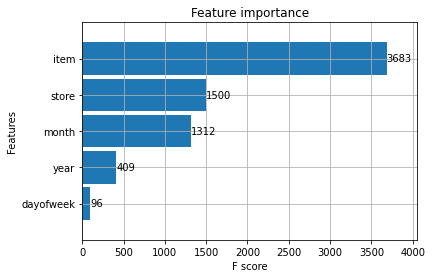

In [ ]:
XG_model_month = xgb.XGBRegressor(n_estimators=1000)
XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], 
                   early_stopping_rounds=50,verbose=False)

# 주요하게 적용하는 변수를 판단
plot_importance(XG_model_month, height=0.9)

In [ ]:
df_test_y

date
2017-01-31     485
2017-02-28     487
2017-03-31     561
2017-04-30     677
2017-05-31     773
              ... 
2017-08-31    2867
2017-09-30    2586
2017-10-31    2507
2017-11-30    2574
2017-12-31    1987
Name: sales, Length: 6000, dtype: int64

In [ ]:
df_test_x

,store,item,month,year,dayofweek
date,,,,,
2017-01-31,1,1,1,2017,1
2017-02-28,1,1,2,2017,1
2017-03-31,1,1,3,2017,4
2017-04-30,1,1,4,2017,6
2017-05-31,1,1,5,2017,2
...,...,...,...,...,...
2017-08-31,10,50,8,2017,3
2017-09-30,10,50,9,2017,5
2017-10-31,10,50,10,2017,1


In [ ]:
# 학습
xgboost = XG_model_month.predict(df_test_x)

In [ ]:
xgboost

array([ 432.41534,  430.57336,  561.85004, ..., 2426.9788 , 2476.2756 ,
       1979.3557 ], dtype=float32)

In [ ]:
df_xgboost = pd.DataFrame(xgboost)
df_xgboost

,0
0,432.415344
1,430.573364
2,561.850037
3,734.123718
4,739.171570
...,...
5995,2705.369629
5996,2494.487305
5997,2426.978760
5998,2476.275635


In [ ]:
df_test_y = df_test_y.to_frame(name='sales')

In [ ]:
df_test_y

,sales
date,
2017-01-31,485
2017-02-28,487
2017-03-31,561
2017-04-30,677
2017-05-31,773
...,...
2017-08-31,2867
2017-09-30,2586
2017-10-31,2507


In [ ]:
df_test_y.reset_index(inplace = True)

In [ ]:
df_test_y

,date,sales
0,2017-01-31,485
1,2017-02-28,487
2,2017-03-31,561
3,2017-04-30,677
4,2017-05-31,773
...,...,...
5995,2017-08-31,2867
5996,2017-09-30,2586
5997,2017-10-31,2507
5998,2017-11-30,2574


In [ ]:
df_xgboost

,0
0,432.415344
1,430.573364
2,561.850037
3,734.123718
4,739.171570
...,...
5995,2705.369629
5996,2494.487305
5997,2426.978760
5998,2476.275635


In [ ]:
df_test_y.index

RangeIndex(start=0, stop=6000, step=1)

In [ ]:
df_test_y

In [ ]:
set(df_xgboost.index) == set(df_test_y.index)

True

In [ ]:
result = pd.concat([df_test_y,df_xgboost],axis=1)

In [ ]:
result

,date,sales,0
0,2017-01-31,485,432.415344
1,2017-02-28,487,430.573364
2,2017-03-31,561,561.850037
3,2017-04-30,677,734.123718
4,2017-05-31,773,739.171570
...,...,...,...
5995,2017-08-31,2867,2705.369629
5996,2017-09-30,2586,2494.487305
5997,2017-10-31,2507,2426.978760
5998,2017-11-30,2574,2476.275635


In [ ]:
type(result)

NoneType

In [ ]:
result.rename(columns = {'0' : 'Xgboost'}, inplace = True)

In [ ]:
result.set_index('date')

,sales,0
date,,
2017-01-31,485,432.415344
2017-02-28,487,430.573364
2017-03-31,561,561.850037
2017-04-30,677,734.123718
2017-05-31,773,739.171570
...,...,...
2017-08-31,2867,2705.369629
2017-09-30,2586,2494.487305
2017-10-31,2507,2426.978760


In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (50,10)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
RMSE_xgboost  = sqrt(mean_squared_error(result['sales'],result[0]))
RMSE_xgboost

193.8734847050824

# **XGB.plot_tree() 메서드란?**

SXBoost 모형객체를 넣어 의사결정트리를 시각화 할 수있다. 기본값으로 트리를 저장하면 읽을 수 없을 정도로 낮은 해상도의 이미지가 생성되는 데  따라서 이미지의 크기나 해상도를 지정하는 옵션을 주어야한다.



```
  import xgboost as xgb
  import matplotlib.pyplot as plt

  # num_trees : 그림을 여러개 그릴시 그림 번호
  # rankdir : 트리의 방향, 디폴트는 위아래 방향
  # rankdir="LR" : 왼쪽에서 오른쪽 방향으로 트리를 보여준다.
  xgb.plot_tree(my_model, num_trees=0, rankdir='LR')

  fig = plt.gcf()
  fig.set_size_inches(150, 100)

  # 이미지 저장하고 싶다면
  # fig.savefig('tree.png')

  plt.show()
```



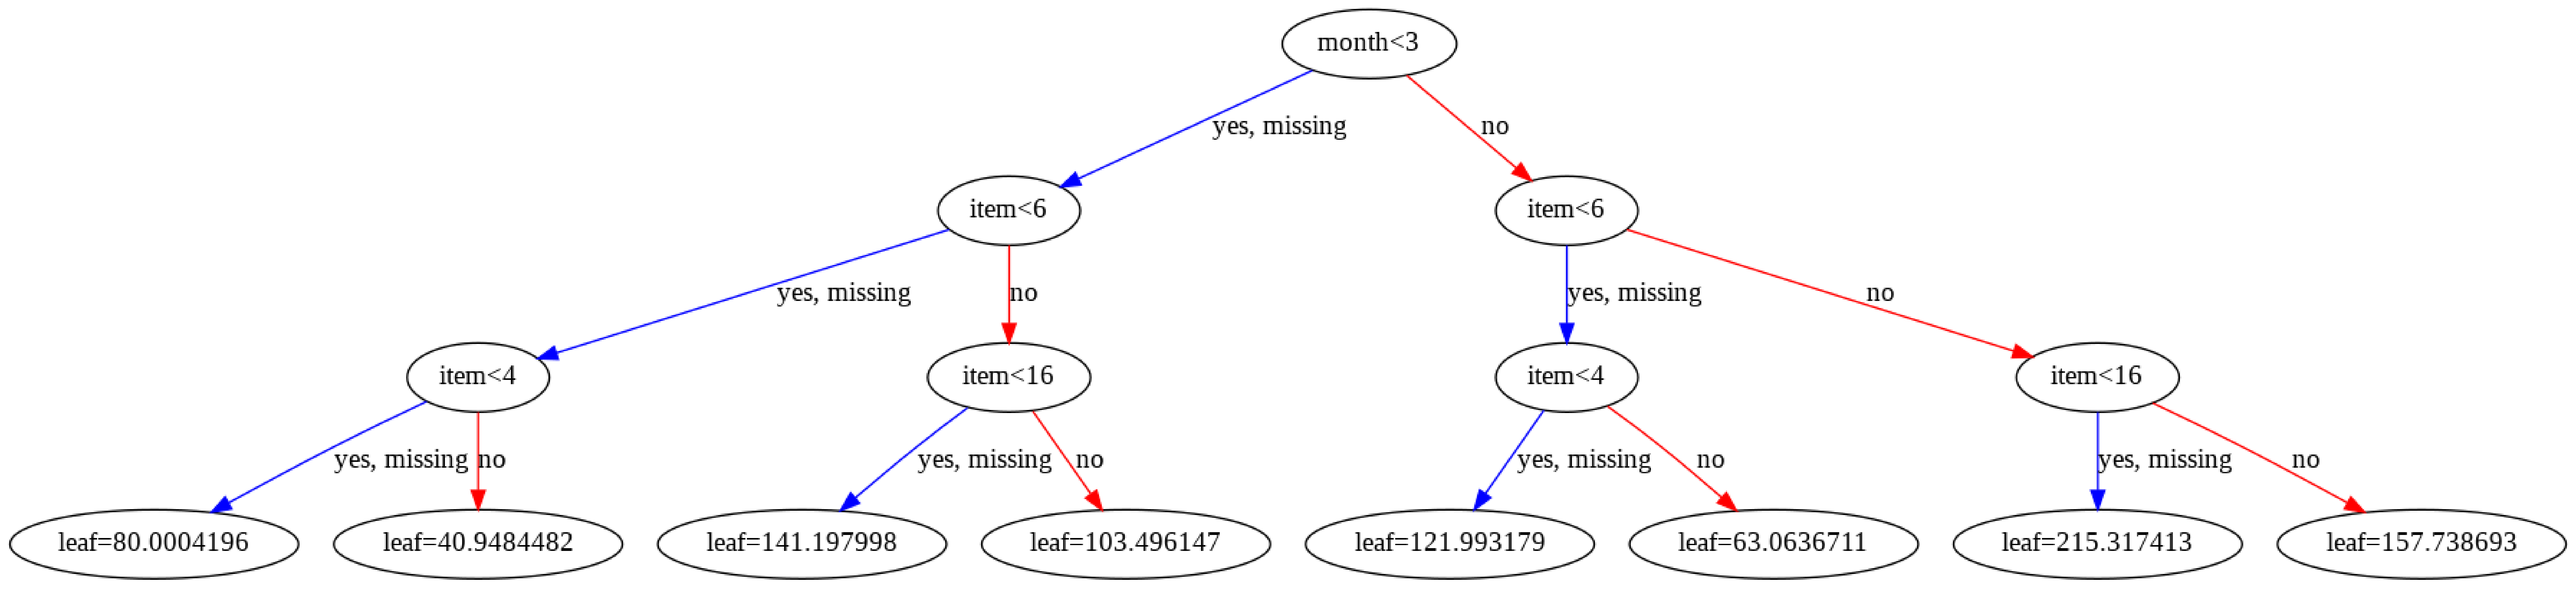

In [ ]:
xgb.plot_tree(XG_model_month, num_trees=0, rankidr="LR")
fig = plt.gcf()
fig.set_size_inches(150,100)

#***TimeSeries - DL***

In [3]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
filename = '/content/drive/MyDrive/TimeSeries/TimeSeries_practice/train.csv'

In [5]:
df = pd.read_csv(filename)
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [6]:
df['date'] =  pd.to_datetime(df['date'])
df = df.set_index('date')

In [ ]:
# # Training/Test ratio = 7:3
# Train_ratio = 0.7
# Test_ratio = 0.3

# # Data load
# x = df.iloc[:,0:-1]
# y = df.iloc[:,-1:]

In [ ]:
# # Data Division

# train_x = x.iloc[0:int(len(df)*Train_ratio),:]
# train_y = y.iloc[0:int(len(df)*Train_ratio),:]
# test_x = x.iloc[int(len(df)*Train_ratio):,:]
# test_y = y.iloc[int(len(df)*Train_ratio):,:]

In [7]:
# store/item 별로 월별 판매 합산
# df = df.sales.resample('M').sum()
df = df.groupby(['store','item'])['sales'].resample('M').sum() #월별 상점과 아이템 별 판매량 합산
df = df.reset_index()
df = df.set_index('date') #1번째 열 date로 바꿔주기

df['month'] = df.index.month
df['year'] = df.index.year
df['dayofweek'] = df.index.dayofweek
df['dayofyear'] = df.index.dayofyear

In [8]:
df.head(3)

,store,item,sales,month,year,dayofweek,dayofyear
date,,,,,,,
2013-01-31,1,1,328,1,2013,3,31
2013-02-28,1,1,322,2,2013,3,59
2013-03-31,1,1,477,3,2013,6,90


In [9]:
# 학습과 테스트 데이터 분리(2013~2016는 train, 2017은 test)
split = "2017-01-01"
df_train = df[:split]
df_test = df[split:]

df_train_y = df_train.loc[:,'sales'] #모든행을 표시하고 sales열만 가져오기
df_train_x = df_train.drop('sales', axis=1) #sales를 제외하고 모든 행, 열 가져오기
df_test_y = df_test.loc[:,'sales']
df_test_x = df_test.drop('sales', axis=1)
# 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
# df_test_orig = df_test.loc[:, ['store', 'item', 'sales']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  after removing the cwd from sys.path.


In [ ]:
df_train_y = df_train_y.to_frame(name='sales')
df_train_y

In [ ]:
df_test_y = df_test_y.to_frame(name='sales')
df_test_y

In [ ]:
train_x_tensor = Variable(torch.Tensor(df_train_x.values))
train_y_tensor = Variable(torch.Tensor(df_train_y.values))
test_x_tensor = Variable(torch.Tensor(df_test_x.values))
test_y_tensor = Variable(torch.Tensor(df_test_y.values))

In [ ]:
# train_y_tensor = torch.transpose(train_y_tensor,1,0)
# test_y_tensor = torch.transpose(test_y_tensor,1,0)

In [ ]:
train_x_tensor.shape[0]

24000

In [ ]:
#input = (samples 수, time step 수, feature 수), 여기서 time step은 하나의 데이터에 들어가는 칼럼 수
#time step = sequence length, 즉 열의 길이
train_x_tensor_final = torch.reshape(train_x_tensor, (train_x_tensor.shape[0],1,train_x_tensor.shape[1]))
train_y_tensor_final = torch.reshape(train_y_tensor, (train_y_tensor.shape[0],1,train_y_tensor.shape[1]))
test_x_tensor_final = torch.reshape(test_x_tensor, (test_x_tensor.shape[0],1,test_x_tensor.shape[1]))
test_y_tensor_final = torch.reshape(test_y_tensor,(test_y_tensor.shape[0],1,test_y_tensor.shape[1]) )

## **Parameters**

input_size – The number of expected features in the input x

hidden_size – The number of features in the hidden state h

num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1

batch_first – If True, then the input and output tensors are provided as (batch, seq, feature). Default: False

In [ ]:
train_x_tensor_final.size()

torch.Size([24000, 1, 6])

In [ ]:
# LSTM network modeling

class LSTM(nn.Module):
    def __init__(self, num_classes,
                 input_size, hidden_size,
                 num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes #lstm의 층수
        self.num_layers = num_layers #layer의 갯수
        self.input_size = input_size #입력 x의 feature 차원
        self.hidden_size = hidden_size
        self.seq_length = seq_length #time step
        self.lstm = nn.LSTM(input_size = input_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers, batch_first = True)
        self.layer_1 = nn.Linear(hidden_size, 256)
        self.layer_2 = nn.Linear(256,256)
        self.layer_3 = nn.Linear(256,128)
        self.layer_out = nn.Linear(128, num_classes)
        self.relu = nn.ReLU() #Activation Func

 #x는 input사이즈를 갖춘 텐서형태의 데이터
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers,
                                   x.size(0), self.hidden_size)).to(device) #Hidden State, # (BATCH SIZE, SEQ_LENGTH, HIDDEN_SIZE)
        c_0 = Variable(torch.zeros(self.num_layers,
                                   x.size(0), self.hidden_size)).to(device) #Internal Process States, Hidden State와 동일
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #output : (BATCH_SIZE, SEQ_LENGTH, HIDDEN_SIZE) tensors
        hn = hn.view(-1, self.hidden_size) # Reshaping the data for starting LSTM network
        out = self.relu(hn) #pre-processing for first layer
        out = self.layer_1(out) # first layer
        out = self.relu(out) # activation func relu
        out = self.layer_2(out)
        out = self.relu(out)
        out = self.layer_3(out)
        out = self.relu(out)
        out = self.layer_out(out) #Output layer

        return out

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


In [ ]:
train_x_tensor_final.size()

torch.Size([24000, 1, 6])

In [ ]:
input_size

6

In [ ]:
# Code Main

num_epochs = 1000
learning_rate = 0.001
input_size = int(len(df_train_x.columns))
hidden_size = 2 #number of features in hidden state
num_layers = 1
num_classes = int(len(df_test_y.columns))
LSTM = LSTM(num_classes, input_size, hidden_size,
                    num_layers,
                    train_x_tensor_final.shape[1]).to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(LSTM.parameters(), lr = learning_rate)

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
for epoch in range(num_epochs): 
    outputs = LSTM.forward(train_x_tensor_final.to(device))
    optimizer.zero_grad() #최적화  
    loss = loss_function(outputs, train_y_tensor.to(device))
    loss.backward() #역전파
    optimizer.step() #improve from loss = back propagation

    if epoch % 200 == 0:
        print("Epoch : %d, loss : %1.5f" % (epoch, loss.item()))

Epoch : 0, loss : 3005311.75000
Epoch : 200, loss : 632557.75000
Epoch : 400, loss : 632553.18750
Epoch : 600, loss : 632553.18750
Epoch : 800, loss : 632553.25000


In [ ]:
test_predict = LSTM(test_x_tensor_final.to(device)) #Forward Pass
predict_data = test_predict.data.detach().cpu().numpy() #numpy conversion

In [ ]:
real_data = test_y_tensor.data.numpy()

In [ ]:
predict_data

array([[1540.4489],
       [1540.4489],
       [1540.4489],
       ...,
       [1540.4489],
       [1540.4489],
       [1540.4489]], dtype=float32)

In [ ]:
real_data

array([[ 485.],
       [ 487.],
       [ 561.],
       ...,
       [2507.],
       [2574.],
       [1987.]], dtype=float32)

In [ ]:
import math
MSE = np.square(np.subtract(real_data,predict_data)).mean() 
RMSE_lstm = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE_lstm)

Root Mean Square Error:

936.9580433509283


In [ ]:
print(f' ARIMA score :{RMSE_score_arima}\n\n XGBoost score :{RMSE_xgboost}\n\n LSTM score :{RMSE_lstm}')